In [84]:
from mesa import Agent, Model

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [85]:
class Robot(Agent):
    def __init__(self, unique_id, model, width, height, dirty_cells):
        super().__init__(unique_id, model)
        
        # Celdas sucias
        self.dirty_cells = dirty_cells
        
        
        # Posicion
        self.position = np.array((1,1), dtype = int)
        
        # Velocidad
        vel_x = np.random.randint(2)
        vel_y = np.random.randint(2)
        self.speed = np.array((vel_x, vel_y), dtype = int)
        
        self.width = width
        self.height = height
        
        # Movimientos realizados por el agente
        self.movimientos = 0
        
        # Posibles direcciones a las que podrá moverse
        self.directions = ["North", "South", "East", "West", 
                      "NorthEast", "NorthWest", "SouthEast", "SouthWest"]
        
        # Celdas limpiadas
        self.cleaned = 0
        
    def step(self):
        self.check_edges()
        self.move()
        if self.clean_cell() == True:
            self.position = self.position + self.speed
            self.movimientos += 1
        
        #print("position = " + str(self.position[0]) + " , " +str(self.position[1]))
        #print(self.directions)
        
    def move(self):
        des = np.random.choice(self.directions)
        if des == 'North':
            self.North()
        elif des == 'South':
            self.South()
        elif des == 'East':
            self.East()
        elif des == 'West':
            self.West()
        elif des == 'NorthEast':
            self.NorthEast()
        elif des == 'NorthWest':
            self.NorthWest()
        elif des == 'SouthEast':
            self.SouthEast()
        elif des == 'SouthWest':
            self.SouthWest()
        
    # Posibles direcciones a las que el robot se puede mover
    def North(self):
        self.speed = np.array((0, 1), dtype = int)
        
    def South(self):
        self.speed = np.array((0, -1), dtype = int)
        
    def East(self):
        self.speed = np.array((1, 0), dtype = int)
        
    def West(self):
        self.speed = np.array((0, -1), dtype = int)
        
    def NorthEast(self):
        self.speed = np.array((1, 1), dtype = int)
        
    def NorthWest(self):
        self.speed = np.array((-1, 1), dtype = int)
        
    def SouthEast(self):
        self.speed = np.array((1, -1), dtype = int)
        
    def SouthWest(self):
        self.speed = np.array((-1, -1), dtype = int)
        
    #Revisar que el robot no salga de los límites establecidos
    def check_edges(self):
        self.directions = ["North", "South", "East", "West", 
                      "NorthEast", "NorthWest", "SouthEast", "SouthWest"]
        
        if self.position.flatten()[0] + 1 >= self.width:
            self.directions.remove("East")
        if self.position.flatten()[0] - 1 <= 0:
            self.directions.remove("West")
        
        if self.position.flatten()[1] + 1 >= self.height:
            self.directions.remove("North")
        if self.position.flatten()[1] - 1 <= 0:
            self.directions.remove("South")
            
        if self.position.flatten()[0] + 1 >= self.width or self.position.flatten()[1] + 1 >= self.height:
            self.directions.remove("NorthEast")
        if self.position.flatten()[0] - 1 <= 0 or self.position.flatten()[1] + 1 >= self.height:
            self.directions.remove("NorthWest")
            
        if self.position.flatten()[0] + 1 >= self.width or self.position.flatten()[1] - 1 <= 0:
            self.directions.remove("SouthEast")
        if self.position.flatten()[0] - 1 <= 0 or self.position.flatten()[1] - 1 <= 0:
            self.directions.remove("SouthWest")
        
    def clean_cell(self):
        for i in self.dirty_cells:
            if self.position[0] == i[0] and self.position[1] == i[1]:
                self.dirty_cells.remove(i)
                self.cleaned += 1
                return False
        return True
        

In [86]:
def get_robots(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

def get_dirty_cells(model):
    result = []
    for agent in model.schedule.agents:
        for i in agent.dirty_cells:
            result.append(i)
    result = np.asarray(result)
    return result

class Cleaning(Model):
    def __init__(self, N, width, height, porcentaje):
        self.num_robots = N
        self.schedule = RandomActivation(self)
        
        count = int((width * height) * (porcentaje/100))
        dirty_cells = []
        for i in range(count):
            pos = []
            x = np.random.randint(width)
            y = np.random.randint(height)
            pos.append(x)
            pos.append(y)
            dirty_cells.append(pos)
            
        for robot in range(self.num_robots):
            r = Robot(robot, self, width, height, dirty_cells)
            self.schedule.add(r)
            
        self.datacollector = DataCollector(model_reporters = {"Robots" : get_robots, "Cells" : get_dirty_cells})
        self.movements = 0
        self.cleaned = 0
            
    def step(self):
        self.datacollector.collect(self)
        self.get_cleaned_cells()
        self.get_movements()
        self.schedule.step()
        
    def get_cleaned_cells(self):
        self.cleaned = 0
        for agent in model.schedule.agents:
            self.cleaned += agent.cleaned

    def get_movements(self):
        self.movements = 0
        for agent in model.schedule.agents:
            self.movements += agent.movimientos


In [87]:
WIDTH = 10
HEIGHT = 10
PERCENTAGE = 10
N = 1
MAX_ITERATIONS = 500

start_time = time.time()

model = Cleaning(N, WIDTH, HEIGHT, PERCENTAGE)
for i in range(MAX_ITERATIONS):
    model.step()

print("Total de movimientos = " + str(model.movements))  
print("Total de celdas limpiadas = " + str(model.cleaned)) 
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Total de movimientos = 490
Total de celdas limpiadas = 9
Tiempo de ejecución: 0:00:00.044869


In [88]:
all_positions = model.datacollector.get_model_vars_dataframe()

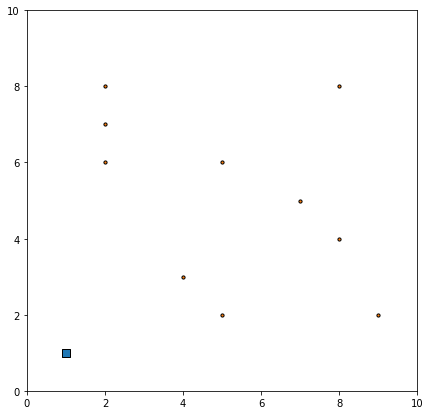

In [89]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], 
                  s=50, cmap="jet", edgecolor="k",  marker="s")
garbage = ax.scatter(all_positions.iloc[0][1][:,0], all_positions.iloc[0][1][:,1], 
                  s=10, cmap="jet", edgecolor="k")
ax.axis([0, WIDTH, 0, HEIGHT])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    garbage.set_offsets(all_positions.iloc[frame_number][1])
    return scatter

anim = animation.FuncAnimation(fig, update, frames=MAX_ITERATIONS)

In [90]:
anim